In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Assignment 4: Bayes Classification

# Question 1

### Performing pre-processing and visualization of the dataset. Splitting the data into train and test sets. Also identifying the useful columns and dropping the unnecessary ones.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score

In [85]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic.csv")

In [86]:
df

,PassengerId,Name,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Braund, Mr. Owen Harris",3,male,22.0,A/5 21171,7.2500,NaN,S,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,PC 17599,71.2833,C85,C,1
2,3,"Heikkinen, Miss. Laina",3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,113803,53.1000,C123,S,1
4,5,"Allen, Mr. William Henry",3,male,35.0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",2,male,27.0,211536,13.0000,NaN,S,0
887,888,"Graham, Miss. Margaret Edith",1,female,19.0,112053,30.0000,B42,S,1
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",3,female,NaN,W./C. 6607,23.4500,NaN,S,0
889,890,"Behr, Mr. Karl Howell",1,male,26.0,111369,30.0000,C148,C,1


In [87]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df

,Pclass,Sex,Age,Fare,Embarked,Survived
0,3,male,22.0,7.2500,S,0
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,1
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0
...,...,...,...,...,...,...
886,2,male,27.0,13.0000,S,0
887,1,female,19.0,30.0000,S,1
888,3,female,NaN,23.4500,S,0
889,1,male,26.0,30.0000,C,1


In [88]:
def handling_missing_values(df):
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df.dropna(axis=0, inplace=True)
    return df


df = handling_missing_values(df)

In [89]:
def encoding(df):
    label_encoder = LabelEncoder()
    cols = ['Sex', 'Embarked']
    for col in cols:
        df[col] = label_encoder.fit_transform(df[col])
    return df

df = encoding(df)

In [90]:
df

,Pclass,Sex,Age,Fare,Embarked,Survived
0,3,1,22.0,7.2500,2,0
1,1,0,38.0,71.2833,0,1
2,3,0,26.0,7.9250,2,1
3,1,0,35.0,53.1000,2,1
4,3,1,35.0,8.0500,2,0
...,...,...,...,...,...,...
886,2,1,27.0,13.0000,2,0
887,1,0,19.0,30.0000,2,1
888,3,0,28.0,23.4500,2,0
889,1,1,26.0,30.0000,0,1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    int64  
 2   Age       889 non-null    float64
 3   Fare      889 non-null    float64
 4   Embarked  889 non-null    int64  
 5   Survived  889 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 48.6 KB


In [92]:
X = df.copy()
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)
X_train_final = X_train.drop(['Survived'],axis=1)
X_test_final = X_test.drop(['Survived'],axis=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train_final.shape, X_test_final.shape)

(622, 6) (267, 6) (622,) (267,)
(622, 5) (267, 5)


### Identifying the best possible variant of naive bayes classifier for the given dataset.

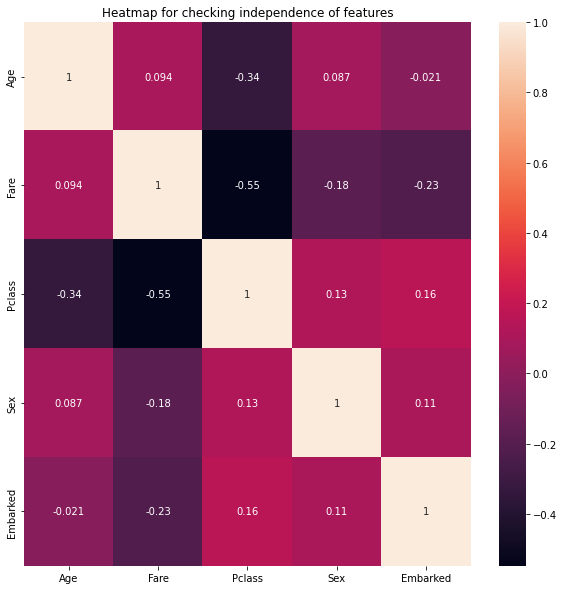

In [93]:
"""Best Possible Variant"""

fig, ax = plt.subplots(figsize=(10,10))

new_df = pd.DataFrame(df, columns=["Age", "Fare", "Pclass","Sex","Embarked"])
corr = new_df.corr()
sns.heatmap(corr, annot =True)
plt.title("Heatmap for checking independence of features")
plt.show()

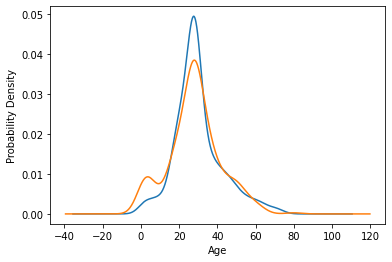

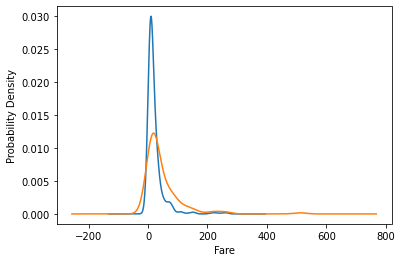

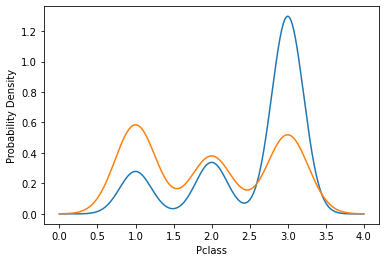

In [94]:
"""Plotting Probability Distribution"""

def plotting_probability_distribution(dataset, feature, target):
    x = df.loc[(df[target]==0),feature]
    x_compliment = df.loc[(df[target]==1),feature]
    x.plot.kde()
    x_compliment.plot.kde()
    plt.xlabel(feature)
    plt.ylabel("Probability Density")
    plt.show()

plotting_probability_distribution(df, "Age", "Survived")
plotting_probability_distribution(df, "Fare", "Survived")
plotting_probability_distribution(df, "Pclass", "Survived")

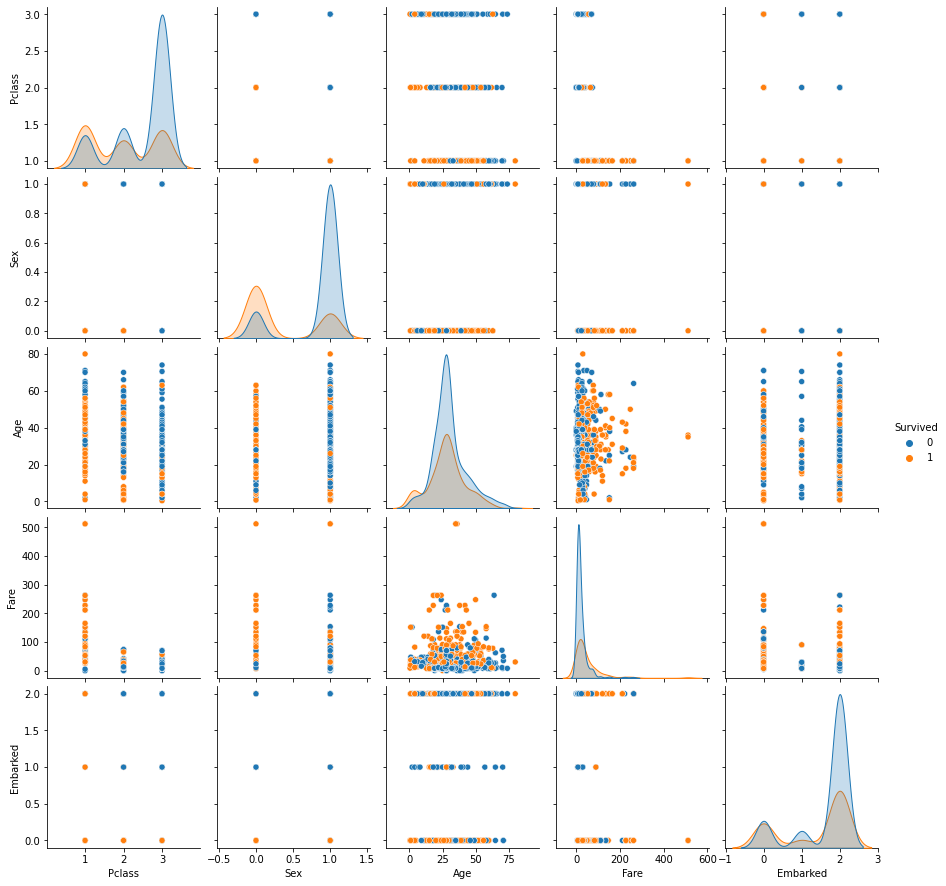

In [95]:
sns.pairplot(df, hue="Survived")

### Implementing the identified variant (Gaussian Naive Bayes) of Naive Bayes Classifier from scratch.

In [96]:
class NaiveBayesClassifier():
    # Calculating prior probabilities

    def calculatePriorProb(self, features, target):
        self.prior = (features.groupby(target).apply(
            lambda x: len(x)) / self.rows).to_numpy()

        return self.prior

    # Calculating statistics like mean and variance

    def calculateStats(self, features, target):
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()

        return self.mean, self.var

    # Calculating gaussian density probability

    def gaussianDensity(self, classx, x):
        mean = self.mean[classx]
        var = self.var[classx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob

    # Calculating posterior probabilities

    def calculatePosteriorProb(self, x):
        posteriors = []

        for i in range(self.count):
            prior = np.log(self.prior[i])
            conditional = np.sum(np.log(self.gaussianDensity(i, x)))
            posterior = prior + conditional
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    # Function for fitting the train data

    def fit(self, features, target, numFeatures):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = numFeatures
        self.rows = features.shape[0]

        self.calculateStats(features, target)
        self.calculatePriorProb(features, target)

    # Function for predicting the classes of test data

    def predict(self, features):
        preds = [self.calculatePosteriorProb(f) for f in features.to_numpy()]
        return preds

    # Calculating accuracy score

    def score(self, y_test, y_pred):
        acc = np.sum(y_test == y_pred) / len(y_test)
        return acc

In [97]:
model = NaiveBayesClassifier()
model.fit(X_train_final, y_train, X_train_final.shape[1])
y_pred = model.predict(X_test_final)
print("Accuracy of Gaussian Classifier implemented from Scratch is: ",model.score(y_test, y_pred))

Accuracy of Gaussian Classifier implemented from Scratch is:  0.7490636704119851


### Performing 5-fold cross-validation using the entire training feature set and visualizing and summarizing the results across the cross-validation sets.

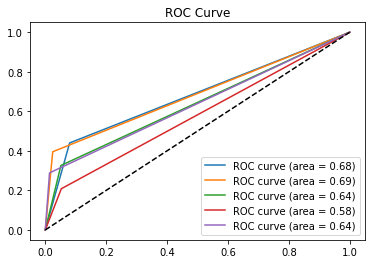

Cross Validation Scores of Scratch Gaussian Navie Bayes Model:  [0.728, 0.776, 0.717741935483871, 0.6612903225806451, 0.6935483870967742]


In [98]:
def five_fold_cross_validation(X, y, model):
    kf = KFold(n_splits=5)
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train, X_train.shape[1])
        y_pred = model.predict(X_test)
        accuracies.append(model.score(y_test, y_pred))
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.show()
    return accuracies

scores = five_fold_cross_validation(X_train_final, y_train, model)
print("Cross Validation Scores of Scratch Gaussian Navie Bayes Model: ", scores)

### Computing the probability of the top class for each row in the testing dataset.

### Comparing my scratch implementation of GuassianNB with scikit-learn GaussianNB in terms of the performance.

In [99]:
gaussian_model = GaussianNB()
gaussian_model.fit(X_train_final, y_train)
y_pred = gaussian_model.predict(X_test_final)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of Gaussian Classifier implemented from Scikit-learn is: ",acc)
scores_from_model = cross_val_score(gaussian_model, X_train_final, y_train, cv=5)
print("Cross Validation Scores of Scikit-learn Gaussian NB Model: ", scores_from_model)

Accuracy of Gaussian Classifier implemented from Scikit-learn is:  0.7827715355805244
Cross Validation Scores of Scikit-learn Gaussian NB Model:  [0.736      0.8        0.77419355 0.75       0.80645161]


### Implementing Multinomial model and Bernaulli Model and performing 5-fold cross-validation and summarizing the results. Comparing the results with the Naive Bayes Classifier

In [100]:
multinomial_model = MultinomialNB()
multinomial_model.fit(X_train_final, y_train)
y_pred = multinomial_model.predict(X_test_final)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of Multinomial Classifier implemented from Scikit-learn is: ",acc)
scores_from_model = cross_val_score(multinomial_model, X_train_final, y_train, cv=5)
print("Cross Validation Scores of Scikit-learn Multinomial NB Model: ", scores_from_model)
print("Mean of Cross Validation Scores: ", scores_from_model.mean())

Accuracy of Multinomial Classifier implemented from Scikit-learn is:  0.6779026217228464
Cross Validation Scores of Scikit-learn Multinomial NB Model:  [0.632      0.712      0.7016129  0.7016129  0.72580645]
Mean of Cross Validation Scores:  0.6946064516129032


In [101]:
bernaulli_model = BernoulliNB()
bernaulli_model.fit(X_train_final, y_train)
y_pred = bernaulli_model.predict(X_test_final)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of Bernoulli Classifier implemented from Scikit-learn is: ",acc)
scores_from_model = cross_val_score(bernaulli_model, X_train_final, y_train, cv=5)
print("Cross Validation Scores of Scikit-learn Bernoulli NB Model: ", scores_from_model)
print("Mean of Cross Validation Scores: ",scores_from_model.mean())

Accuracy of Bernoulli Classifier implemented from Scikit-learn is:  0.8202247191011236
Cross Validation Scores of Scikit-learn Bernoulli NB Model:  [0.76       0.784      0.76612903 0.75       0.7983871 ]
Mean of Cross Validation Scores:  0.7717032258064516


# Question 2

There are 210 rows with 7 input variables and 1 output variable. The variable names are
as given:
1. Area.
2. Perimeter.
3. Compactness
4. Length of kernel.
5. Width of kernel.
6. Asymmetry coefficient.

7. Length of kernel groove.
8. Class (1, 2, 3).

### Reading the data

In [102]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset_q2.csv")
df.columns = ['Area', 'Perimeter', 'Compactness', 'Length of Kernel', 'Width of Kernel', 'Asymmetry Coefficient', 'Length of Kernel Grove', 'Class(1,2,3)']

print(df.head())

    Area  Perimeter  ...  Length of Kernel Grove  Class(1,2,3)
0  15.26      14.84  ...                   5.220             1
1  14.88      14.57  ...                   4.956             1
2  14.29      14.09  ...                   4.825             1
3  13.84      13.94  ...                   4.805             1
4  16.14      14.99  ...                   5.175             1

[5 rows x 8 columns]


In [103]:
print(df.columns)

Index(['Area', 'Perimeter', 'Compactness', 'Length of Kernel',
       'Width of Kernel', 'Asymmetry Coefficient', 'Length of Kernel Grove',
       'Class(1,2,3)'],
      dtype='object')


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Area                    210 non-null    float64
 1   Perimeter               210 non-null    float64
 2   Compactness             210 non-null    float64
 3   Length of Kernel        210 non-null    float64
 4   Width of Kernel         210 non-null    float64
 5   Asymmetry Coefficient   210 non-null    float64
 6   Length of Kernel Grove  210 non-null    float64
 7   Class(1,2,3)            210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [105]:
df.describe()

,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymmetry Coefficient,Length of Kernel Grove,"Class(1,2,3)"
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


### Using histogram to plot the distribution of samples.

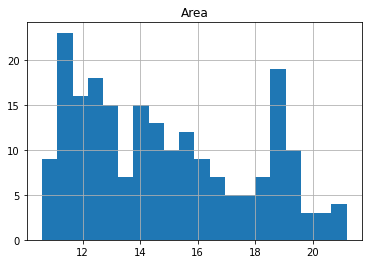

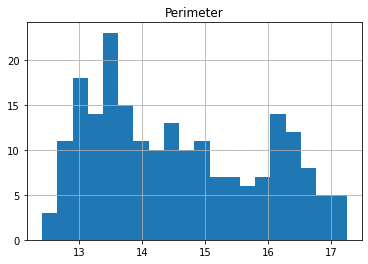

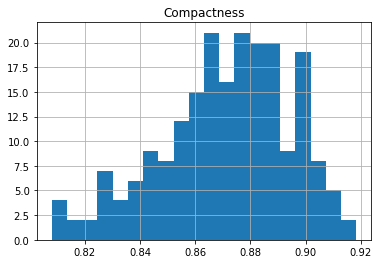

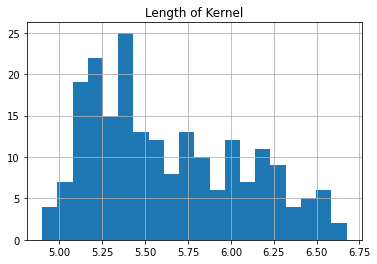

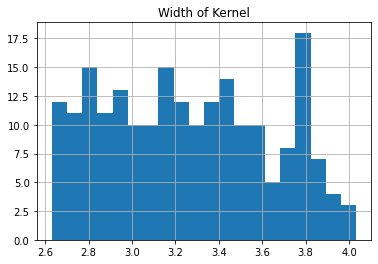

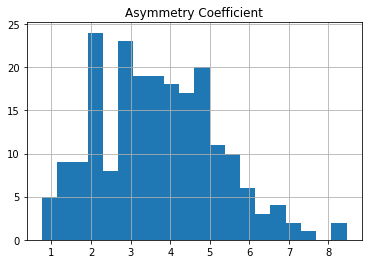

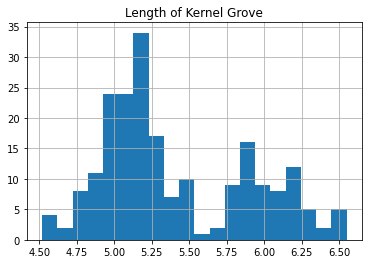

In [106]:
def plotting_histogram_of_distribution_of_samples(df):
    features = list(df.columns[:-1])
    for feature in features:
        df[feature].hist(bins=20)
        plt.title(feature)
        plt.show()

plotting_histogram_of_distribution_of_samples(df)

### Determine the prior probability for all the classes.

In [107]:
def prior_probabilities(df):
    classes = df['Class(1,2,3)'].unique()
    prior_probability = {}
    for cls in classes:
        prior_probability[cls] = len(df[df['Class(1,2,3)'] == cls]) / len(df)
    return prior_probability

print(prior_probabilities(df))

{1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333}


### Discretize the features into bins from scratch.

In [108]:
df2 = df.copy()
df2

,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymmetry Coefficient,Length of Kernel Grove,"Class(1,2,3)"
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [109]:
features=['Area','Perimeter','Compactness','Length of Kernel','Width of Kernel','Asymmetry Coefficient','Length of Kernel Grove']
def discretize_features(df, features):
    # Deciding the basis of the size of the bins.
    new_list = []
    for feature in features:
        q75, q25 = np.percentile(df[feature], [75 ,25])
        iqr = q75 - q25
        temp = 2*(iqr/((df.shape[0])**(1/3)))
        new_list.append(temp)

    # Calculating the bin size for each feature.
    all_bin_list = []
    for feature in features:
        difference_val = df[feature].max() - df[feature].min()
        all_bin_list.append(round(difference_val/new_list[features.index(feature)]))

    # Segregate the data into bins.
    for i in range(len(all_bin_list)):
        value = all_bin_list[i]
        min_val = df[features[i]].min()
        max_val = df[features[i]].max()
        for j in range(value):
            if(j!=value-1):
                df2.loc[(df2[features[i]] >= min_val + j*(max_val-min_val)/value) & (df2[features[i]] < min_val + (j+1)*(max_val-min_val)/value), features[i]] = j
            else:
                df2.loc[(df2[features[i]] >= min_val + j*(max_val-min_val)/value) & (df2[features[i]] <= max_val), features[i]] = j
    return df2
df2 = discretize_features(df2, features)
df2

,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymmetry Coefficient,Length of Kernel Grove,"Class(1,2,3)"
0,2.0,3.0,6.0,3.0,3.0,1.0,2.0,1
1,2.0,2.0,7.0,2.0,3.0,0.0,1.0,1
2,2.0,2.0,9.0,1.0,3.0,2.0,1.0,1
3,1.0,1.0,8.0,1.0,3.0,1.0,0.0,1
4,3.0,3.0,9.0,2.0,6.0,0.0,2.0,1
...,...,...,...,...,...,...,...,...
205,0.0,0.0,7.0,0.0,1.0,3.0,1.0,3
206,0.0,0.0,4.0,0.0,0.0,4.0,1.0,3
207,1.0,1.0,8.0,1.0,3.0,9.0,1.0,3
208,0.0,0.0,4.0,1.0,1.0,3.0,1.0,3


### Determining the likelihood/class conditional probabilities for all the classes.

In [110]:
def likelihood_conditional_probabilities(df):
    classes = df['Class(1,2,3)'].unique()

    likelihood_conditional_probability = {}
    
    for cls in classes:
        likelihood_conditional_probability[cls] = {}
        for feature in features:
            likelihood_conditional_probability[cls][feature] = {}

            for i in range(int(df2[feature].max()+1)):
                likelihood_conditional_probability[cls][feature][i] = len(df2[(df2['Class(1,2,3)'] == cls) & (df2[feature] == i)]) / len(df2[df2['Class(1,2,3)'] == cls])

    return likelihood_conditional_probability
likelihoods = likelihood_conditional_probabilities(df2)
for i in features:
    for j in likelihoods:
        print("For the class ", j, " the likelihood of ", i, " is ", likelihoods[j][i])

For the class  1  the likelihood of  Area  is  {0: 0.05714285714285714, 1: 0.37142857142857144, 2: 0.4714285714285714, 3: 0.1, 4: 0.0, 5: 0.0}
For the class  2  the likelihood of  Area  is  {0: 0.0, 1: 0.0, 2: 0.07142857142857142, 3: 0.24285714285714285, 4: 0.5, 5: 0.18571428571428572}
For the class  3  the likelihood of  Area  is  {0: 0.7142857142857143, 1: 0.2857142857142857, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
For the class  1  the likelihood of  Perimeter  is  {0: 0.04285714285714286, 1: 0.24285714285714285, 2: 0.5285714285714286, 3: 0.18571428571428572, 4: 0.0, 5: 0.0}
For the class  2  the likelihood of  Perimeter  is  {0: 0.0, 1: 0.0, 2: 0.014285714285714285, 3: 0.18571428571428572, 4: 0.4714285714285714, 5: 0.32857142857142857}
For the class  3  the likelihood of  Perimeter  is  {0: 0.4714285714285714, 1: 0.5285714285714286, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
For the class  1  the likelihood of  Compactness  is  {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.02857142857142857, 4: 0.05714285714285714, 

In [111]:
def plotting_likelihoods_for_3_classes(likelihood_conditional_probability):
    for feature in features:
        for cls in likelihood_conditional_probability:
            plt.plot(list(likelihood_conditional_probability[cls][feature].values()), label=cls, marker='o')
        plt.title(feature)
        plt.xlabel('Bins')
        plt.ylabel('Likelihood')
        plt.legend()
        plt.show()

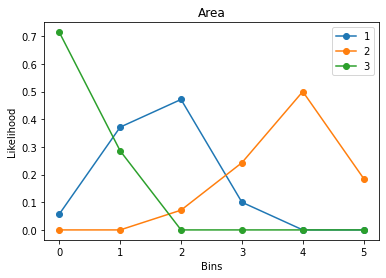

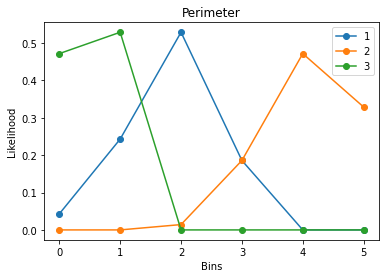

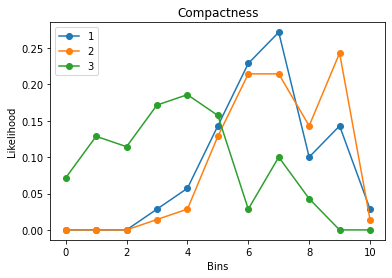

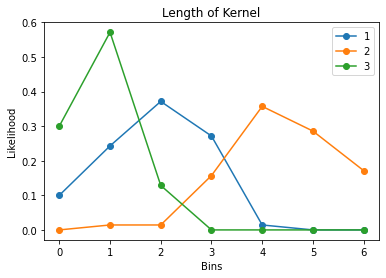

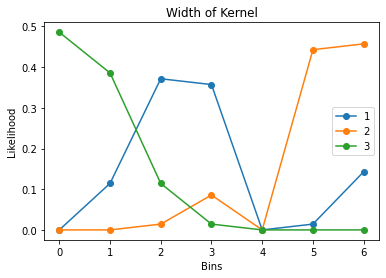

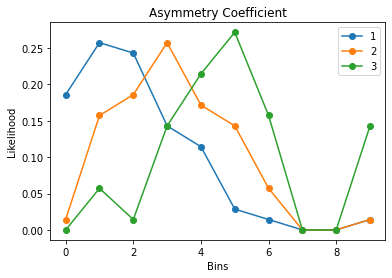

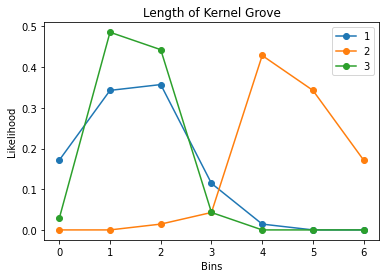

In [112]:
plotting_likelihoods_for_3_classes(likelihoods)

### Plot the count of each unique element for each class. 

In [113]:
def plotting_count_of_each_class(df, features):
    complete_list = []
    for feature in features:
        vals = list(df[feature].unique())
        inner_list = []
        for val in vals:
            ans = (df2.loc[df2[feature] == val, feature].shape[0])
            inner_list.append(ans)
        complete_list.append(inner_list)
    for i in complete_list:
        x_ax = [i for i in range(len(i))]
        plt.plot(x_ax, i, marker='o')
        plt.title('Count of each element for each class')
        plt.xlabel('Bins')
        plt.ylabel('Count')
        plt.legend()
        plt.show()

No handles with labels found to put in legend.


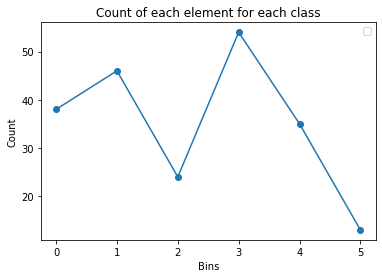

No handles with labels found to put in legend.


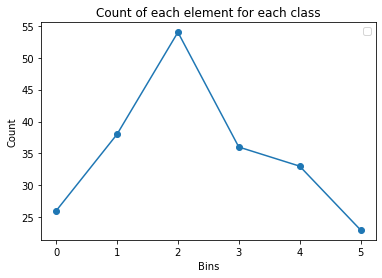

No handles with labels found to put in legend.


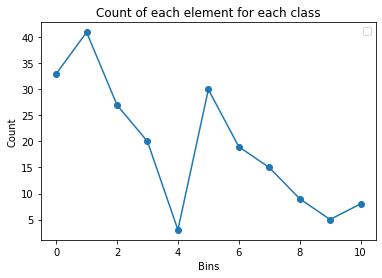

No handles with labels found to put in legend.


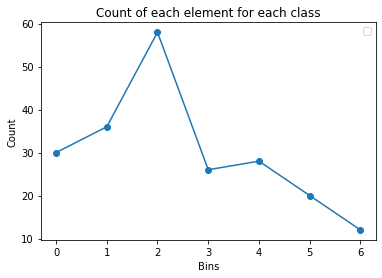

No handles with labels found to put in legend.


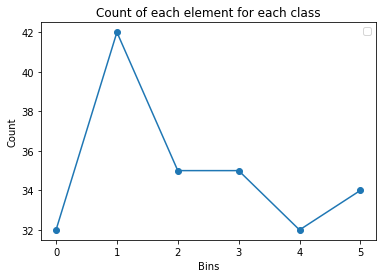

No handles with labels found to put in legend.


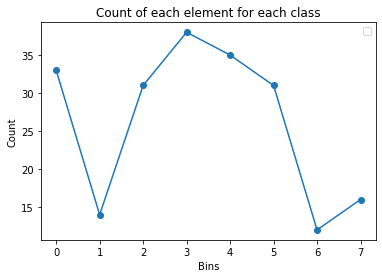

No handles with labels found to put in legend.


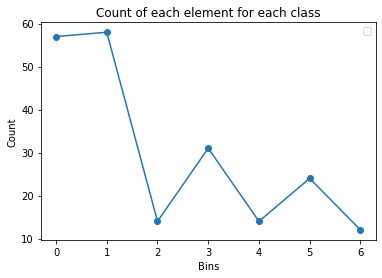

In [114]:
plotting_count_of_each_class(df2, features)

### Compare the plot with the plot of distribution.

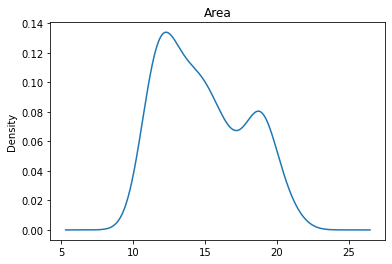

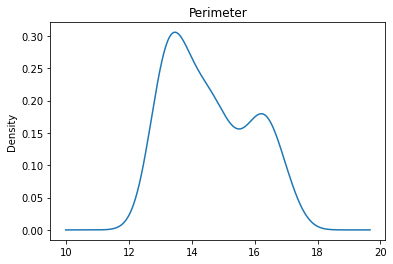

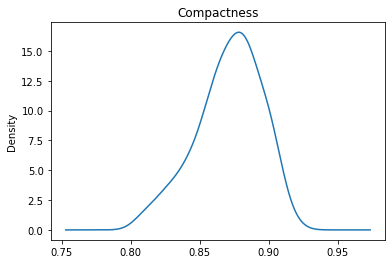

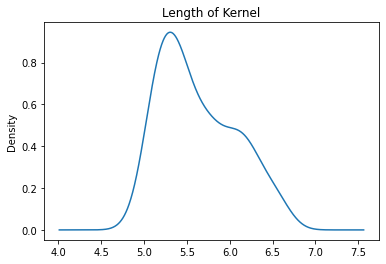

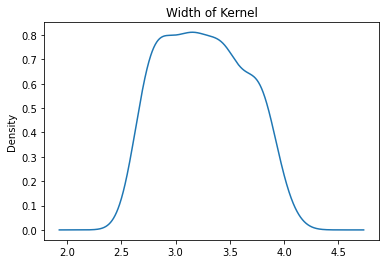

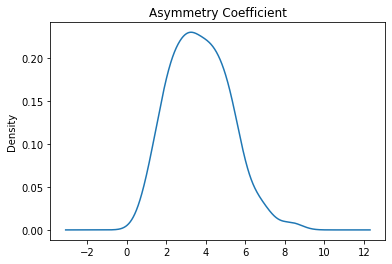

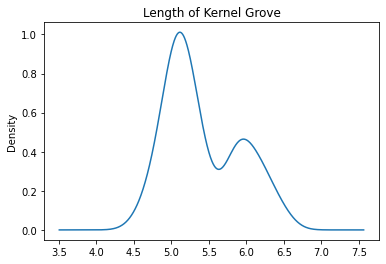

In [115]:
for feature in features:
    plt.title(feature)
    df[feature].plot.kde()
    plt.show()

### Calculating the posterior probabilities and plotting them in a single graph and analysying the plot.

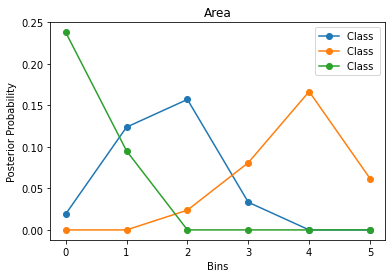

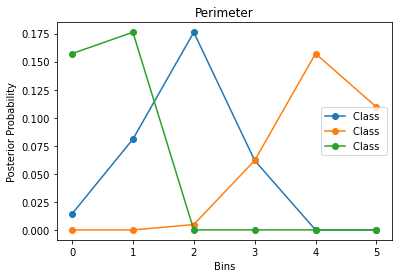

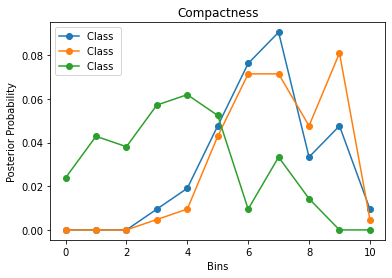

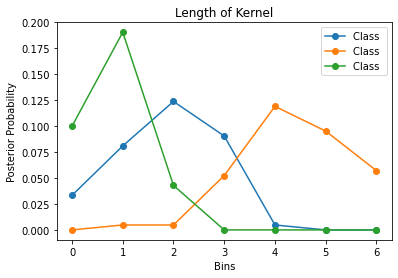

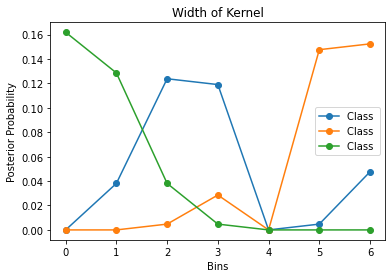

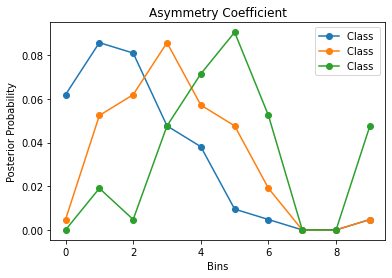

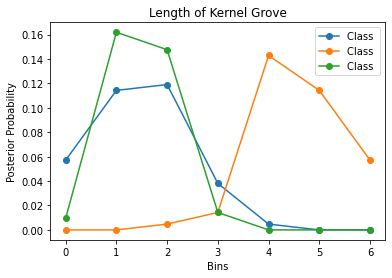

In [116]:
def plotting_posterior_probabilities(likelihoods, prior_probability, features):
    posterior_probability = {}
    for cls in likelihoods:
        posterior_probability[cls] = {}
        for feature in features:
            posterior_probability[cls][feature] = {}
            for i in range(int(df2[feature].max()+1)):
                posterior_probability[cls][feature][i] = (prior_probability[cls] * likelihoods[cls][feature][i])
    for feature in features:
        for cls in posterior_probability:
            x_ax = [i for i in range(len(posterior_probability[cls][feature]))]
            plt.plot(x_ax, list(posterior_probability[cls][feature].values()), marker='o', label = 'Class ')
        plt.title(feature)
        plt.xlabel('Bins')
        plt.ylabel('Posterior Probability')
        plt.legend()
        plt.show()

priors = prior_probabilities(df2)
plotting_posterior_probabilities(likelihoods, priors, features)